### Ozzie Liu
### Benson Challenge
#### MTA Turnstile Data Analysis

In [2]:
import datetime
import pandas as pd
import collections

In [3]:
import pprint
pp = pprint.PrettyPrinter(width = 140)

## Challenge 1

Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row

### `read_file(filename)`
Helper function that reads the turnstile data of given filename and returns a flat data frame

In [4]:
def read_file(filename):
    data = pd.read_csv(filename)
    
    ## Just return first 500
#     data = data.head(500)

    
    return data

### `build_dictionary(df)`
Helper function that takes a flat data frame input:

`[C/A, UNIT, SCP, STATION, LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS]`

and transforms and outputs it to a dictionary:

```
(C/A, UNIT, SCP, STATION) : [ [LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS],
                              [LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS],
                              ...
                            ]
```

In [5]:
def build_dictionary(raw):
    ## the new dictionary. use defaultdict for simplicity
    my_dict = collections.defaultdict(list)
    
    # For loop to add to defaultdict
    for row_index, row in raw.iterrows():
        key = tuple(row[0:4])
        value = row[4:].tolist()
        
        ## Add them to the dictionary
        my_dict[key].append(value)
          
    return my_dict

In [6]:
## Runs the helper functions to read the file and build dictionary
filename = 'turnstile_150404.txt'
raw = read_file(filename)
# raw.head(3)

my_dictionary = build_dictionary(raw)
# pp.pprint(dict(my_dictionary))

## Challenge 2
Change data into a time series by converting date and time to datetime format

### `convert_datetime(dict)`
`covert_datetime(dict)` takes dictionary `dict` and converts the date and time columns to pandas' datetime format, keeping only the date and entry data

input:
```
(C/A, UNIT, SCP, STATION) : [ [LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS], 
                              [LINENAME, DIVISION, DATE, TIME, DESC, ENTRIES, EXITS], ...
                            ]
```

output:
```
(C/A, UNIT, SCP, STATION) : [ [DATETIME, ENTRIES],
                              [DATETIME, ENTRIES], ...
                            ]
```

In [7]:
def convert_datetime(my_dict):
    return { turnstile:[[pd.to_datetime(date + time, format='%m/%d/%Y%H:%M:%S'), entry] 
                                   for _, _, date, time, _, entry, _ in data] 
                                  for turnstile, data in my_dict.items() }

In [8]:
datetime_dict = convert_datetime(my_dictionary)

# pp.pprint(datetime_dict)
# dict(datetime_dict.items()[0:2])

### Challenge 3
Calculate the total number of passengers that entered through each turnstile on each day.

### `calculate_daily_total(dictionary)`
This function takes a dictionary with datetime format and calculates the daily total
Input:
```
(C/A, UNIT, SCP, STATION) : [ [DATETIME (12AM), ENTRIES],
                              [DATETIME (4AM), ENTRIES], ...
                            ]
```
Output:
```
(C/A, UNIT, SCP, STATION) : [ [DATETIME (day 1), TOTAL ENTRIES],
                              [DATETIME (day 2), TOTAL ENTRIES], ...
                            ]
```

The approach here is to 
1. Find the set of all days observed in the timeframe of the file.
2. Get all the time periods and entries data pairs of each day into a list
3. Calculate today's minimum entry number from tomorrow's minimum. This ensures an accurate 24 hour period
  - If there's no tomorrow, because it's already the last day, then use the maximum entry value of the same day
4. Use this result and create a new dictionary with the proper keys
5. Return the dictionary

In [9]:
def calculate_daily_total(my_dictionary):
    result = dict()
    
    ## Get set of dates for turnstile file from first entry    ## This is unordered
    dates = {datetime.date() for datetime, entry in my_dictionary.values()[0]}
    
    ## loop through each turnstile key and data
    for turnstile_key, turnstile_data in my_dictionary.items():
        result_list = list()
        
        ## loop through each date
        for date in dates:
            tomorrows_date = date + datetime.timedelta(days = 1)
            todays_entries = [entry for day, entry in turnstile_data if day.date() == date]
            
            ## Check if there's a tomorrow. If tomorrow doesn't exist, just throw back a 0
            try:
                if tomorrows_date in dates:
                    tomorrows_entries = [entry for day, entry in turnstile_data if day.date() == tomorrows_date]
                    result_list.append([date, min(tomorrows_entries) - min(todays_entries)])
                else:
                    result_list.append([date, max(todays_entries)-min(todays_entries)])
            except:
                result_list.append([date, 0])
                
        ## Add this result to the result dictionary
        result[turnstile_key] = result_list    
    return result

In [10]:
daily_total = calculate_daily_total(datetime_dict)
# pp.pprint(daily_total)

## Challenge 4
Plot the daily time series for a turnstile.  
Input takes a dictionary processed with daily totals, and a specific turnstile key

In [22]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline


## This function takes a dictionary and the turnstile's unique key and plots a simple time series plot
def plot_turnstile(dictionary, key):
    turnstile_data = sorted(dictionary[key])
    
    dates = [x[0] for x in turnstile_data]
    counts = [x[1] for x in turnstile_data]

    plt.figure(figsize=(16,8))
    
    plt.plot(dates, counts)

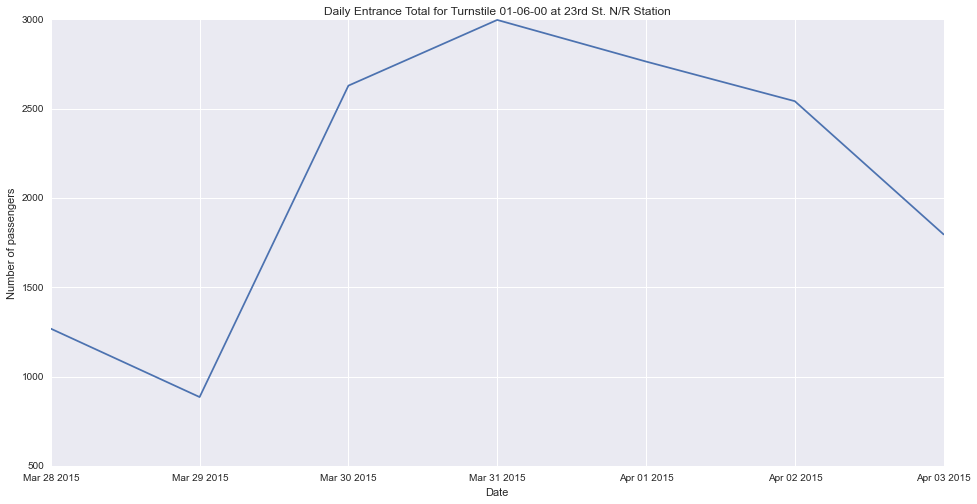

In [24]:
plot_turnstile(daily_total, ('A030','R083','01-06-00','23 ST-5 AVE'))
plt.title('Daily Entrance Total for Turnstile 01-06-00 at 23rd St. N/R Station')
plt.xlabel('Date')
plt.ylabel('Number of passengers')

## Challenge 5
Combine turnstiles in the same ControlArea/Unit/Station combo.

input:
```
(C/A, UNIT, SCP, STATION) : [ [DATETIME (day 1), TOTAL ENTRIES],
                              [DATETIME (day 2), TOTAL ENTRIES], ...
                            ]
```
output:
```
(C/A, UNIT, STATION) : [ [DATETIME (day 1), TOTAL ENTRIES],
                         [DATETIME (day 2), TOTAL ENTRIES], ...
                       ]
```

In [19]:
def calculate_station_total(dictionary):
    station_dict = collections.defaultdict(list)

    ## Combine all stations in a dictionary
    for index, turnstile_data in dictionary.items():
#         print index, turnstile_data
        
        ## Sum up the total of entries across turnstiles by adding it to a temporary dictionary.
        turnstile_total = dict()
        for date, entry in turnstile_data:
            if date not in turnstile_total:
                turnstile_total[date] = entry
            else:
                turnstile_total[date] += entry

        station_dict[ (index[0], index[1], index[3]) ] = [[date, entry] for date, entry in turnstile_total.items()]

    return dict(station_dict)

In [20]:
station_total = calculate_station_total(daily_total)
# station_total = calculate_station_total(daily_total)

# pp.pprint(station_total)

## Challenge 7
Plot the time series for a station.

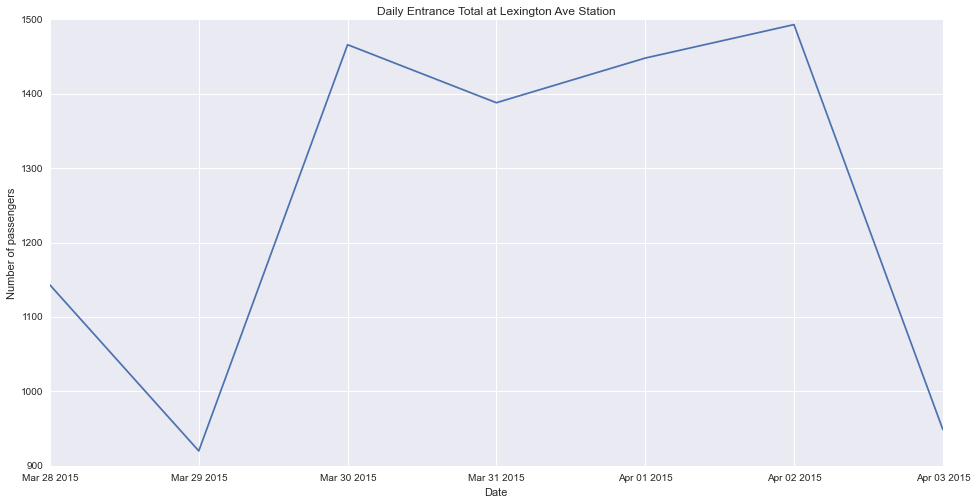

In [26]:
plot_turnstile(station_total, ('A002','R051','LEXINGTON AVE'))
plt.title('Daily Entrance Total at Lexington Ave Station')
plt.xlabel('Date')
plt.ylabel('Number of passengers')

## Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts.  
Make the same list for another week, and another week, and another week.  

plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

Gets a station, and pull the last 6 weeks of data, reads it, process it, and plot the weekly schedule.

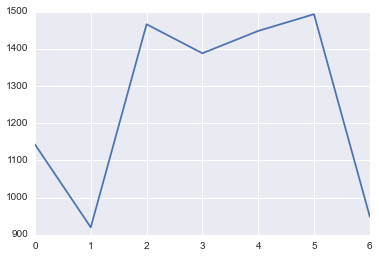

In [27]:
## Test functions
station = ('A002','R051','LEXINGTON AVE')
week1 = [entry for date, entry in sorted(station_total[station])]

plt.plot(week1)

`plot_weekly` will take a list of raw files and the station id and plot a graph of Sunday-Saturday subway entrances

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_weekly(station, file_list):

    plt.figure(figsize=(16,8))
    
    for file in file_list:
        raw = read_file('Raw/'+file)
        dictionary = build_dictionary(raw)
        datetime_dict = convert_datetime(dictionary)
        daily_total = calculate_daily_total(datetime_dict)
        station_total = calculate_station_total(daily_total)
        week = [entry for date, entry in sorted(station_total[station])]

        
        plt.plot(week)
    
    plt.show()

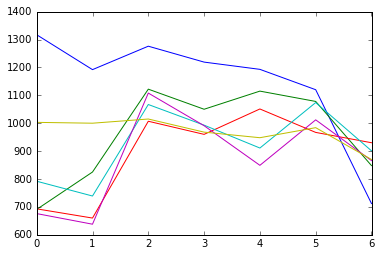

In [25]:
file_names = ['turnstile_150404.txt', 'turnstile_150411.txt', 'turnstile_150418.txt', 'turnstile_150425.txt',
            'turnstile_150502.txt', 'turnstile_150509.txt']

station = ('N067', 'R012', '34 ST-PENN STA')

plot_weekly(station, file_names)

## Challenge 9
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [26]:
## The script below gets all the data from a 6 week period from the file_names list, processes it, and sums up the total ridership
## total_ridership is a dictionary that holds the data, which we can subsequently plot, and sort to see the most popular stations

total_ridership = dict()

for file in file_names:
    raw = read_file('Raw/'+file)
    dictionary = build_dictionary(raw)
    datetime_dict = convert_datetime(dictionary)
    daily_total = calculate_daily_total(datetime_dict)
    station_total = calculate_station_total(daily_total)
    
    for station, entries in station_total.items():
        if station in total_ridership:
            total_ridership[station] += sum([count for _, count in entries])
        else:
            total_ridership[station] = sum([count for _, count in entries])  


In [ ]:
pp.pprint(total_ridership)

In [ ]:
## Print a list of the most popular subwa stations in this 6 weeks
sorted(total_ridership.items(), key = lambda x: x[1], reverse = True)
